In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics import tsaplots 
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
import itertools

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace import sarimax

%matplotlib inline

In [2]:
df = pd.read_csv('../data/interim/airports.csv', index_col=0)

In [3]:
df.head()

,ANC,ATL,BOI,BZN,DEN,DFW,FLL,LAS,LAX,MCO,MIA,MSO,PDX,PHX,SEA,SFO,SJC,TPA
2018-12-30 00:00:00,115.0,11.0,NaN,NaN,123.0,NaN,0.0,343.0,533.0,NaN,283.0,NaN,14.0,389.0,50.0,318.0,NaN,1.0
2018-12-30 01:00:00,14.0,14.0,NaN,NaN,52.0,NaN,147.0,84.0,11.0,NaN,290.0,NaN,11.0,64.0,12.0,7.0,NaN,NaN
2018-12-30 02:00:00,29.0,10.0,NaN,NaN,19.0,NaN,NaN,60.0,NaN,NaN,314.0,NaN,24.0,16.0,110.0,NaN,NaN,NaN
2018-12-30 03:00:00,115.0,216.0,NaN,25.0,353.0,351.0,396.0,762.0,474.0,535.0,704.0,NaN,527.0,524.0,717.0,195.0,35.0,20.0
2018-12-30 04:00:00,305.0,1308.0,483.0,331.0,3006.0,2140.0,3217.0,3189.0,3778.0,3501.0,1796.0,190.0,1778.0,1919.0,3114.0,2361.0,420.0,2267.0


In [4]:
df = df.fillna(0)
df.head()

,ANC,ATL,BOI,BZN,DEN,DFW,FLL,LAS,LAX,MCO,MIA,MSO,PDX,PHX,SEA,SFO,SJC,TPA
2018-12-30 00:00:00,115.0,11.0,0.0,0.0,123.0,0.0,0.0,343.0,533.0,0.0,283.0,0.0,14.0,389.0,50.0,318.0,0.0,1.0
2018-12-30 01:00:00,14.0,14.0,0.0,0.0,52.0,0.0,147.0,84.0,11.0,0.0,290.0,0.0,11.0,64.0,12.0,7.0,0.0,0.0
2018-12-30 02:00:00,29.0,10.0,0.0,0.0,19.0,0.0,0.0,60.0,0.0,0.0,314.0,0.0,24.0,16.0,110.0,0.0,0.0,0.0
2018-12-30 03:00:00,115.0,216.0,0.0,25.0,353.0,351.0,396.0,762.0,474.0,535.0,704.0,0.0,527.0,524.0,717.0,195.0,35.0,20.0
2018-12-30 04:00:00,305.0,1308.0,483.0,331.0,3006.0,2140.0,3217.0,3189.0,3778.0,3501.0,1796.0,190.0,1778.0,1919.0,3114.0,2361.0,420.0,2267.0


In [5]:
df.isna().any().sum()

0

In [6]:
df.duplicated().any()

False

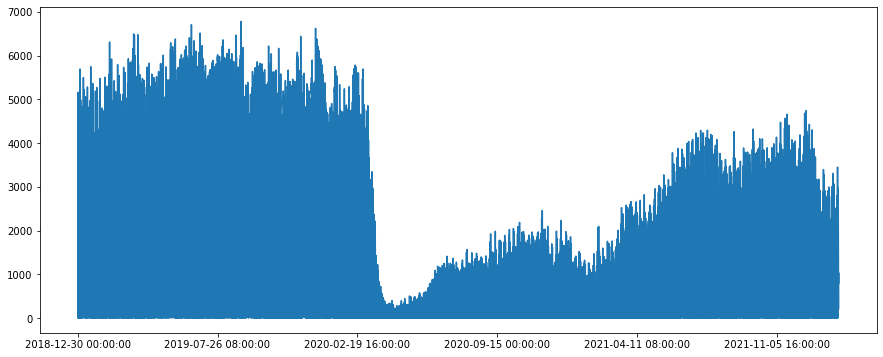

In [7]:
df.SFO.plot(figsize=(15,6));

In [8]:
decomposition = seasonal_decompose(df.SFO, period=24)

<Figure size 432x288 with 0 Axes>

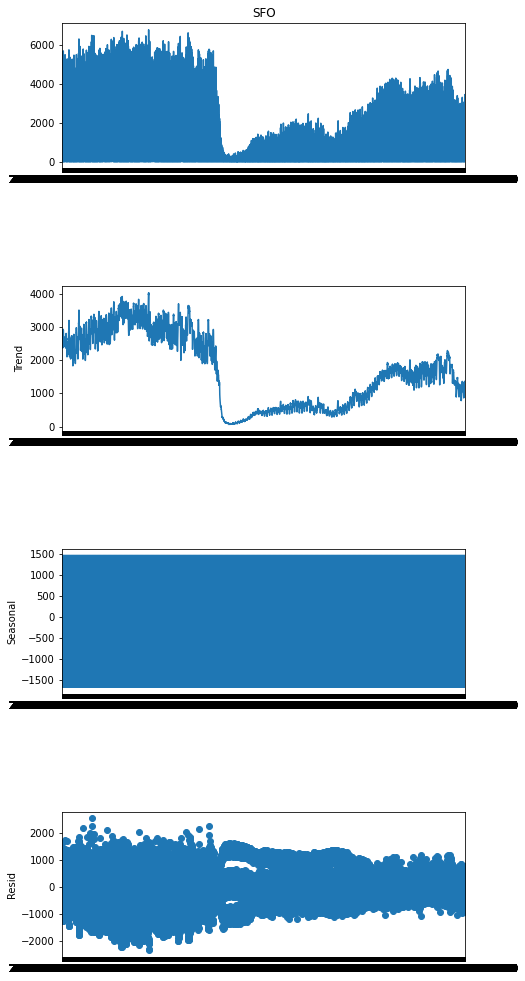

In [9]:
fig = plt.figure()  
fig = decomposition.plot();  
fig.set_size_inches(8, 16)

In [ ]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(24).mean()
    rolstd = timeseries.rolling(24).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [ ]:
test_stationarity(df.SFO)

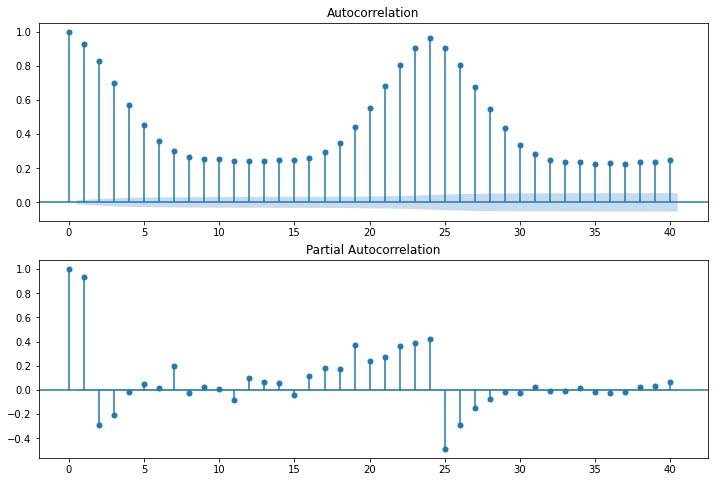

In [12]:
# Autocorrelation and Partial Autocorrelation Plots for original timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.SFO.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.SFO.dropna(), lags=40, ax=ax2)

The autocorrelation plot decays slowly. The series is not stationary.

Seasonality with period 24

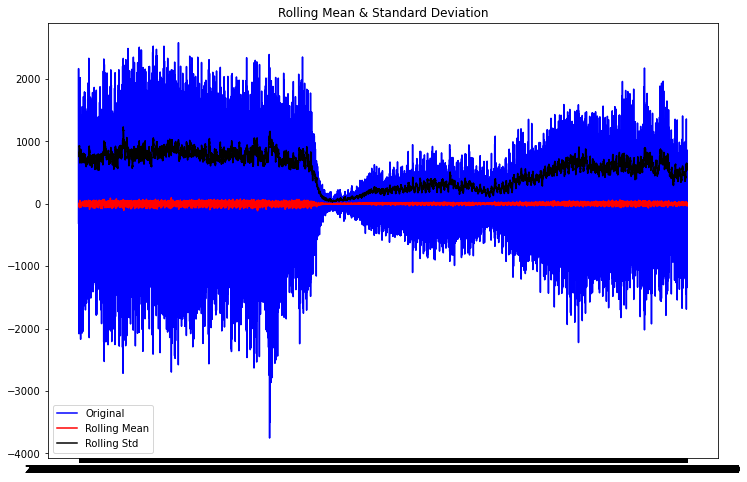

Results of Dickey-Fuller Test:
Test Statistic                   -36.546992
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    27165.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [13]:
# First differenced
df['first_difference']=df.loc[:,'SFO'] - df.loc[:,'SFO'].shift(1)
test_stationarity(df.first_difference.dropna())

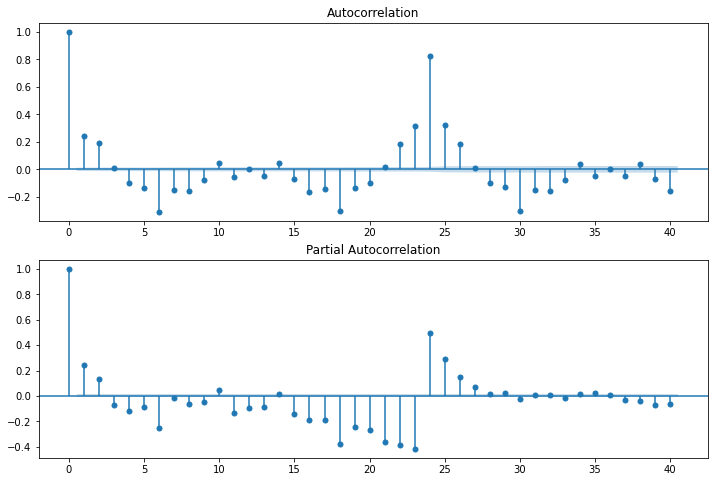

In [14]:
# Autocorrelation and Partial Autocorrelation Plots for first differenced timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.first_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.first_difference.dropna(), lags=40, ax=ax2)

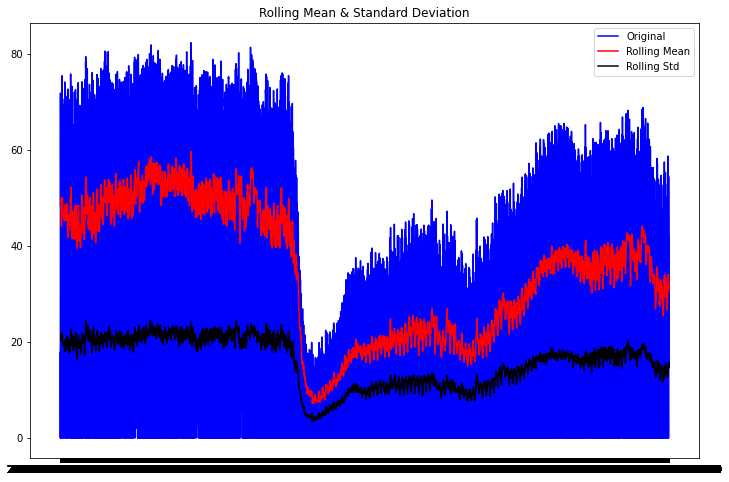

Results of Dickey-Fuller Test:
Test Statistic                    -2.574756
p-value                            0.098328
#Lags Used                        49.000000
Number of Observations Used    27166.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [15]:
# Remove variance by taking the square root
df['no_variance']=np.sqrt(df.SFO)
test_stationarity(df.no_variance.dropna())

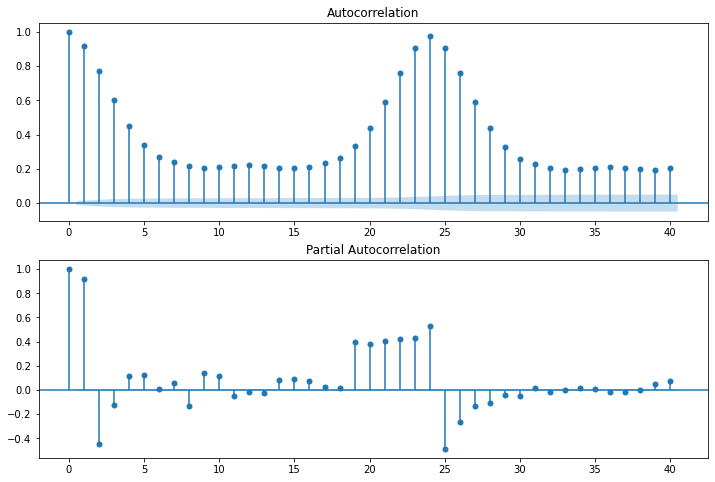

In [16]:
# Autocorrelation and Partial Autocorrelation Plots for no variance timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.no_variance.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.no_variance.dropna(), lags=40, ax=ax2)

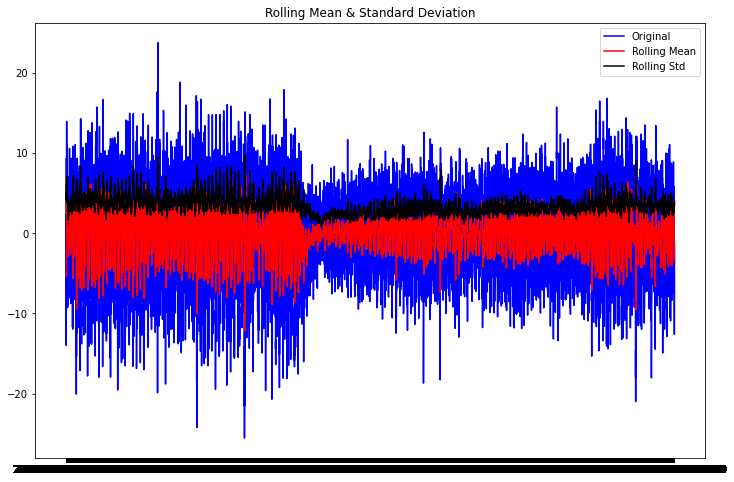

Results of Dickey-Fuller Test:
Test Statistic                   -33.081346
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    27142.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [17]:
# First difference and square root
df['novariance_first_diff']=np.sqrt(df.SFO) - np.sqrt(df.SFO.shift(24))
test_stationarity(df.novariance_first_diff.dropna())

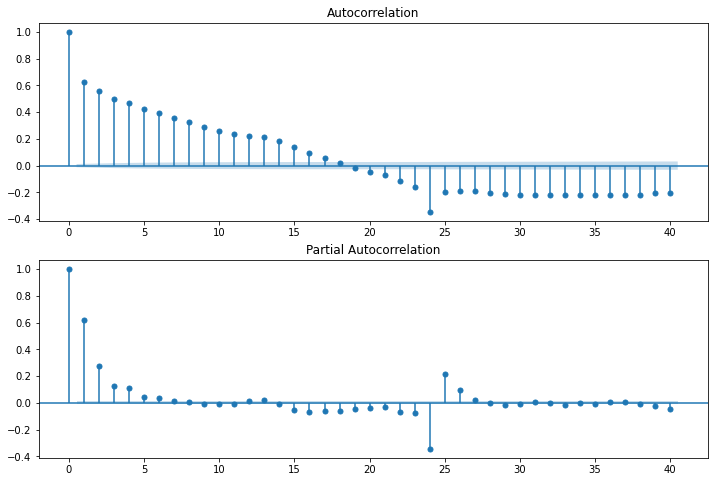

In [18]:
# Autocorrelation and Partial Autocorrelation Plots for no variance timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.novariance_first_diff.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.novariance_first_diff.dropna(), lags=40, ax=ax2)

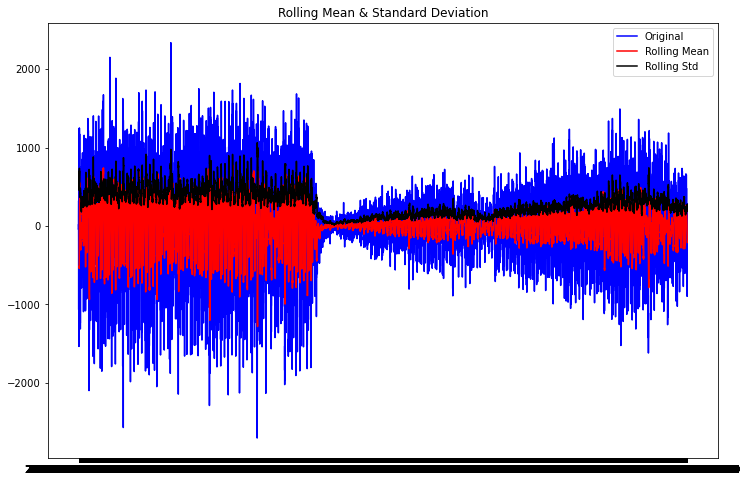

Results of Dickey-Fuller Test:
Test Statistic                   -32.831917
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    27142.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [19]:
# Seasonal differenced
df['seasonal_difference']=df.SFO - df.SFO.shift(24)
test_stationarity(df.seasonal_difference.dropna())

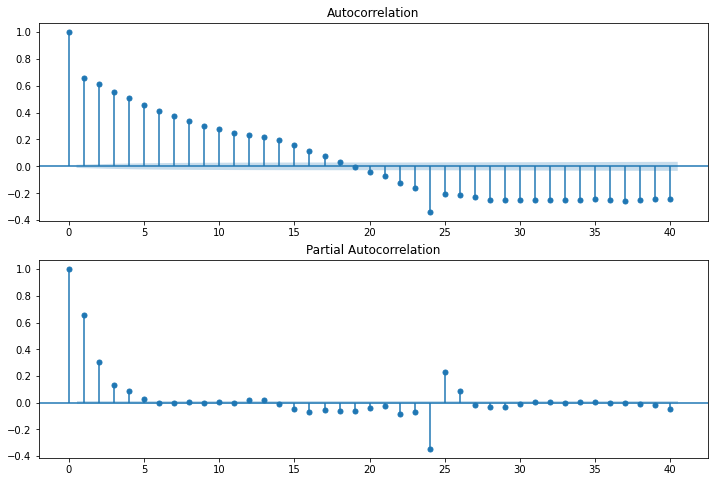

In [20]:
# Autocorrelation and Partial Autocorrelation Plots for seasonally differenced timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_difference.dropna(), lags=40, ax=ax2)

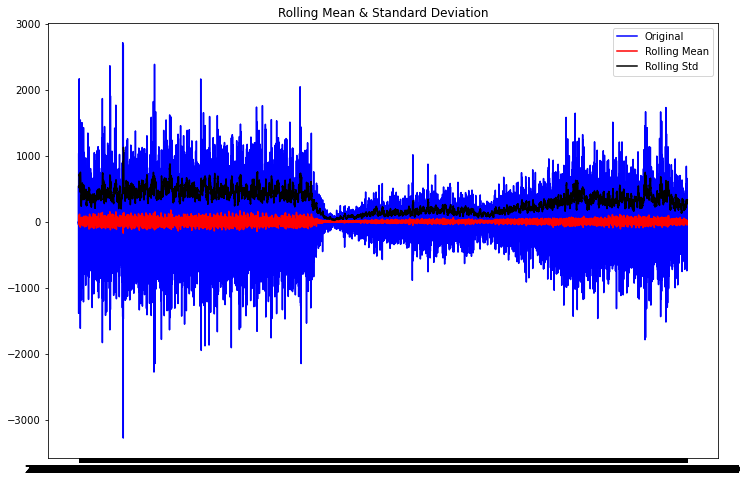

Results of Dickey-Fuller Test:
Test Statistic                   -40.758452
p-value                            0.000000
#Lags Used                        49.000000
Number of Observations Used    27141.000000
Critical Value (1%)               -3.430591
Critical Value (5%)               -2.861646
Critical Value (10%)              -2.566827
dtype: float64


In [21]:
# Seasonal and non-seasonal differenced
df['seasonal_first_difference']=df.first_difference - df.first_difference.shift(24)
test_stationarity(df.seasonal_first_difference.dropna())

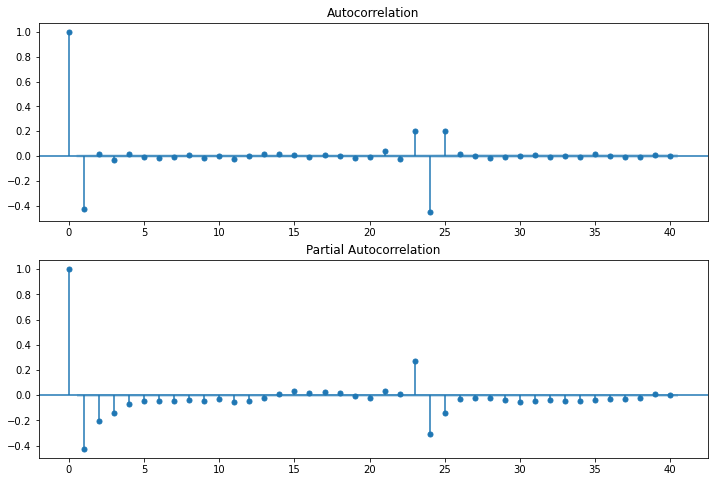

In [22]:
# Autocorrelation and Partial Autocorrelation Plots for first and seaonal first differenced timeseries for SFO
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.dropna(), lags=40, ax=ax2)

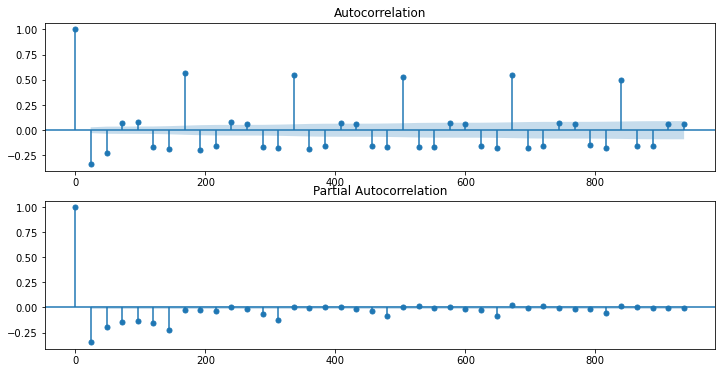

In [23]:
# Seasonal autocorrelation for seasonally adjusted series
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
lags=[l*24 for l in range(40)]
sm.graphics.tsa.plot_acf(df.seasonal_difference.dropna(),  lags=lags, ax=ax1)
sm.graphics.tsa.plot_pacf(df.seasonal_difference.dropna(), lags=lags, ax=ax2)
plt.show()

/Users/shaghayeghroshan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


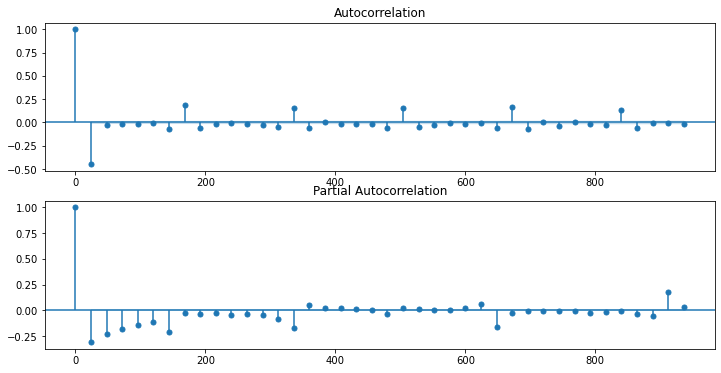

In [24]:
# Seasonal autocorrelation for seasonally differenced series
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(12,6))
lags=[l*24 for l in range(40)]
sm.graphics.tsa.plot_acf(df.seasonal_first_difference.dropna(),  lags=lags, ax=ax1)
sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.dropna(), lags=lags, ax=ax2)
plt.show()

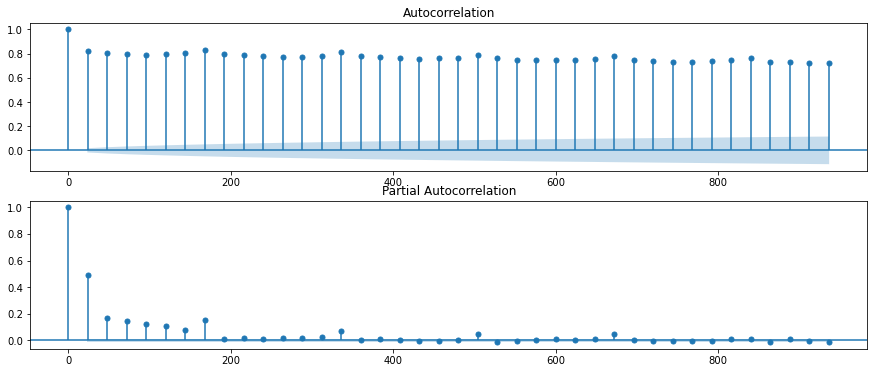

In [25]:
# Seasonal autocorrelation for first differenced series
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(15,6))
lags=[l*24 for l in range(40)]
sm.graphics.tsa.plot_acf(df.first_difference.dropna(),  lags=lags, ax=ax1)
sm.graphics.tsa.plot_pacf(df.first_difference.dropna(), lags=lags, ax=ax2)
plt.show()

276.0974183583407


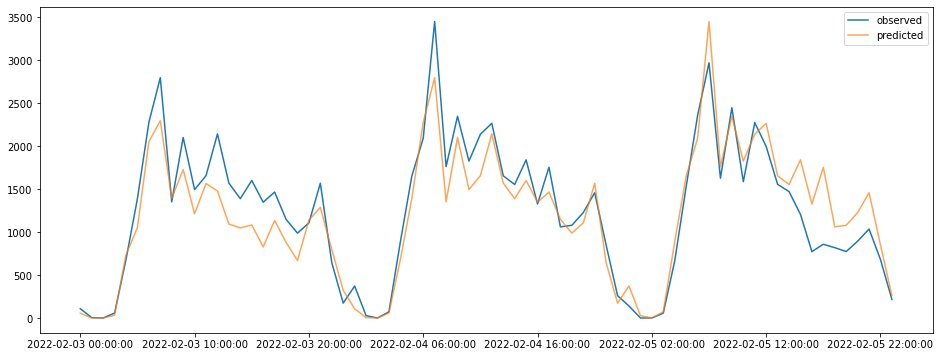

In [7]:
# Base model using yesterday's data
base_model_prediction = df.SFO.shift(24)

error = (df.SFO-base_model_prediction).dropna()
print(sum(abs(error))/len(error))

ax = df.SFO.iloc[-72:].plot(label='observed', figsize=(16,6))
ax.plot(base_model_prediction[-72:], alpha=0.7, label='predicted')
ax.legend()

plt.show()

In [9]:
# Define the p, d and q parameters to take any value between 0 and 2
p = q = range(0, 4)
d = range(0,3)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of p, q and q triplets and seasonal P, D, Q n n
seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[3], seasonal_pdq[5]))
print('SARIMAX: {} x {}'.format(pdq[4], seasonal_pdq[1]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 24)
SARIMAX: (0, 0, 1) x (0, 0, 2, 24)
SARIMAX: (0, 0, 3) x (0, 1, 1, 24)
SARIMAX: (0, 1, 0) x (0, 0, 1, 24)


In [10]:
def evaluate_arima_model(data, order, seasonal_order):
    tscv = TimeSeriesSplit(n_splits=5,
        max_train_size=10000,
        test_size=1000)

    for train_index, test_index in tscv.split(data):
        train, test = data.reset_index().loc[train_index], data.reset_index().loc[test_index]
        # print("TRAIN:", train_index, "TEST:", test_index)

    train = train.set_index(train['index'], drop=True)
    test = test.set_index(test['index'])
    
    past = [x for x in train.SFO]
    model = SARIMAX(past, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=0)
    pred = model_fit.get_prediction(start=-72,dynamic=False)
    pred_ci = pred.conf_int()
    
    error = (train.SFO.iloc[-72:]-pred.predicted_mean).dropna()
    error_avg = sum(abs(error))/len(error)
    #print(error_avg)
    return error_avg

In [11]:
# Make a function to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, arima, seasonal):
    best_score, best_cfg, best_scfg=float('inf'), None, None
    for params in pdq:
        for seasonal_params in seasonal_pdq:
            try:
                mean_error = evaluate_arima_model(dataset, params, seasonal_params)
                if mean_error < best_score:
                        best_score, best_cfg, best_scfg = mean_error, params, seasonal_params
                print('ARIMA: {} X {}, MEAN ERROR = {}'.format(params, seasonal_params, mean_error))
            except:
                continue
    return print('Best ARIMA: {} X {}, MEAN ERROR = {}'.format(best_cfg, best_scfg, best_score))

In [ ]:
# Find the optimum ARIMA parameters
import warnings
warnings.filterwarnings("ignore")
evaluate_models(df.SFO, pdq, seasonal_pdq)

ARIMA: (0, 0, 0) X (0, 0, 0, 24), MEAN ERROR = 1809.611111111111
ARIMA: (0, 0, 0) X (0, 0, 1, 24), MEAN ERROR = 973.0269371564108
ARIMA: (0, 0, 0) X (0, 0, 2, 24), MEAN ERROR = 693.806620882434
ARIMA: (0, 0, 0) X (0, 0, 3, 24), MEAN ERROR = 536.7429548450084
ARIMA: (0, 0, 0) X (0, 1, 0, 24), MEAN ERROR = 307.09722222222223
ARIMA: (0, 0, 0) X (0, 1, 1, 24), MEAN ERROR = 301.1577770764681
ARIMA: (0, 0, 0) X (0, 1, 2, 24), MEAN ERROR = 268.71203265331764
ARIMA: (0, 0, 0) X (0, 1, 3, 24), MEAN ERROR = 281.85968847064197
ARIMA: (0, 0, 0) X (0, 2, 0, 24), MEAN ERROR = 513.3472222222222
ARIMA: (0, 0, 0) X (0, 2, 1, 24), MEAN ERROR = 307.81791524687264
ARIMA: (0, 0, 0) X (0, 2, 2, 24), MEAN ERROR = 309.07049375468836
ARIMA: (0, 0, 0) X (0, 2, 3, 24), MEAN ERROR = 275.6360123880529
ARIMA: (0, 0, 0) X (1, 0, 0, 24), MEAN ERROR = 300.4915048375391
ARIMA: (0, 0, 0) X (1, 0, 1, 24), MEAN ERROR = 299.4314852893491
ARIMA: (0, 0, 0) X (1, 0, 3, 24), MEAN ERROR = 277.301860776631
ARIMA: (0, 0, 0) X (1,

ARIMA: (0, 0, 2) X (3, 0, 0, 24), MEAN ERROR = 1809.611111111111
ARIMA: (0, 0, 2) X (3, 0, 2, 24), MEAN ERROR = 259.282877455989
ARIMA: (0, 0, 2) X (3, 1, 0, 24), MEAN ERROR = 234.3887489320801
ARIMA: (0, 0, 2) X (3, 1, 1, 24), MEAN ERROR = 237.0876203509323
ARIMA: (0, 0, 2) X (3, 1, 2, 24), MEAN ERROR = 236.16620634618428
ARIMA: (0, 0, 2) X (3, 1, 3, 24), MEAN ERROR = 194.65397204887782
ARIMA: (0, 0, 2) X (3, 2, 0, 24), MEAN ERROR = 266.59000646806766
ARIMA: (0, 0, 2) X (3, 2, 1, 24), MEAN ERROR = 236.04026497373096
ARIMA: (0, 0, 2) X (3, 2, 2, 24), MEAN ERROR = 238.77135095937774
ARIMA: (0, 0, 2) X (3, 2, 3, 24), MEAN ERROR = 251.23582253276786
ARIMA: (0, 0, 3) X (0, 0, 0, 24), MEAN ERROR = 663.5487402334992
ARIMA: (0, 0, 3) X (0, 0, 1, 24), MEAN ERROR = 463.3986752024727
ARIMA: (0, 0, 3) X (0, 0, 2, 24), MEAN ERROR = 381.47684915823925
ARIMA: (0, 0, 3) X (0, 0, 3, 24), MEAN ERROR = 339.94495726875914
ARIMA: (0, 0, 3) X (0, 1, 0, 24), MEAN ERROR = 255.6544514701714
ARIMA: (0, 0, 3) X

ARIMA: (0, 1, 1) X (2, 0, 3, 24), MEAN ERROR = 200.77664849485097
ARIMA: (0, 1, 1) X (2, 1, 0, 24), MEAN ERROR = 217.46384409266653
ARIMA: (0, 1, 1) X (2, 1, 1, 24), MEAN ERROR = 194.69054491568272
ARIMA: (0, 1, 1) X (2, 1, 2, 24), MEAN ERROR = 194.11705664347497
ARIMA: (0, 1, 1) X (2, 1, 3, 24), MEAN ERROR = 197.94829581715865
ARIMA: (0, 1, 1) X (2, 2, 0, 24), MEAN ERROR = 283.3440218350653
ARIMA: (0, 1, 1) X (2, 2, 1, 24), MEAN ERROR = 218.41031115157296
ARIMA: (0, 1, 1) X (2, 2, 2, 24), MEAN ERROR = 219.3533407266424
ARIMA: (0, 1, 1) X (2, 2, 3, 24), MEAN ERROR = 196.62807406513775
ARIMA: (0, 1, 1) X (3, 0, 2, 24), MEAN ERROR = 189.87821589274495
ARIMA: (0, 1, 1) X (3, 0, 3, 24), MEAN ERROR = 193.70342335145395
ARIMA: (0, 1, 1) X (3, 1, 0, 24), MEAN ERROR = 210.7044996555029
ARIMA: (0, 1, 1) X (3, 1, 1, 24), MEAN ERROR = 196.37772130675003
ARIMA: (0, 1, 1) X (3, 1, 2, 24), MEAN ERROR = 202.72419899517493
ARIMA: (0, 1, 1) X (3, 1, 3, 24), MEAN ERROR = 180.58565313355933
ARIMA: (0, 1,

ARIMA: (0, 2, 0) X (1, 1, 2, 24), MEAN ERROR = 362.6290331662519
ARIMA: (0, 2, 0) X (1, 1, 3, 24), MEAN ERROR = 362.62593560420066
ARIMA: (0, 2, 0) X (1, 2, 0, 24), MEAN ERROR = 632.8312538513405
ARIMA: (0, 2, 0) X (1, 2, 1, 24), MEAN ERROR = 410.3470744477811
ARIMA: (0, 2, 0) X (1, 2, 2, 24), MEAN ERROR = 362.95590543949544
ARIMA: (0, 2, 0) X (1, 2, 3, 24), MEAN ERROR = 374.080999959736
ARIMA: (0, 2, 0) X (2, 0, 0, 24), MEAN ERROR = 397.2237420763062
ARIMA: (0, 2, 0) X (2, 0, 1, 24), MEAN ERROR = 362.81138809126367
ARIMA: (0, 2, 0) X (2, 0, 2, 24), MEAN ERROR = 367.6183036732434
ARIMA: (0, 2, 0) X (2, 0, 3, 24), MEAN ERROR = 360.5399440043904
ARIMA: (0, 2, 0) X (2, 1, 0, 24), MEAN ERROR = 395.234807079825
ARIMA: (0, 2, 0) X (2, 1, 1, 24), MEAN ERROR = 362.99100703033037
ARIMA: (0, 2, 0) X (2, 1, 2, 24), MEAN ERROR = 362.62976059364337
ARIMA: (0, 2, 0) X (2, 1, 3, 24), MEAN ERROR = 368.01494155005673
ARIMA: (0, 2, 0) X (2, 2, 0, 24), MEAN ERROR = 541.7188963803987
ARIMA: (0, 2, 0) X (2